In [65]:
import re
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

In [66]:
# Import emotions dataset from our data lake
emotions_df = pd.read_csv(
    'emotions/emotions-dataset',
    names=['Text', 'Emotion'], 
    sep=';'
)

In [67]:
emotions_df.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [68]:
emotions_df.shape

(20000, 2)

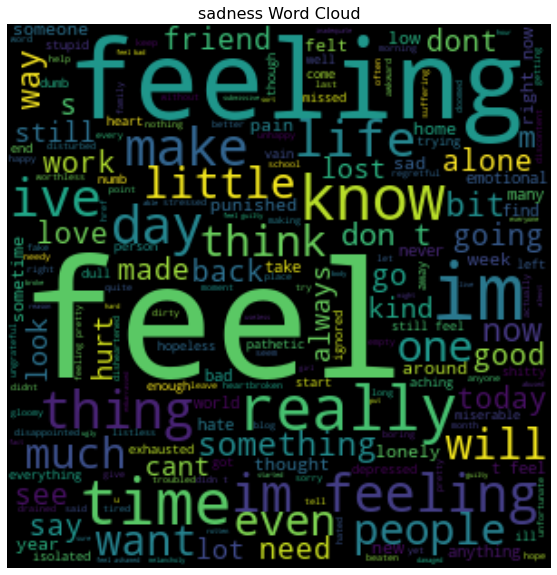

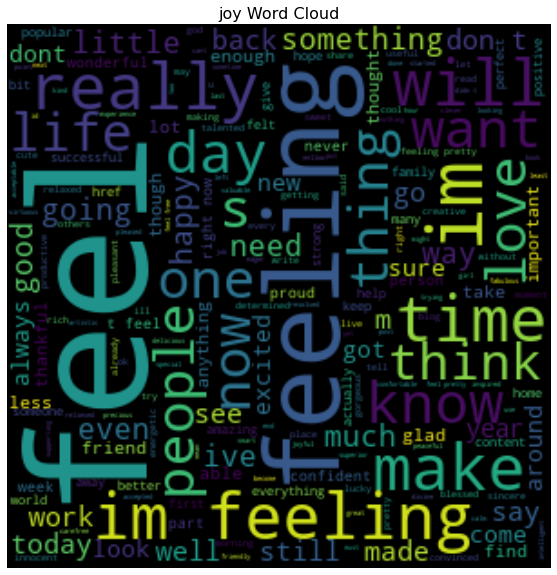

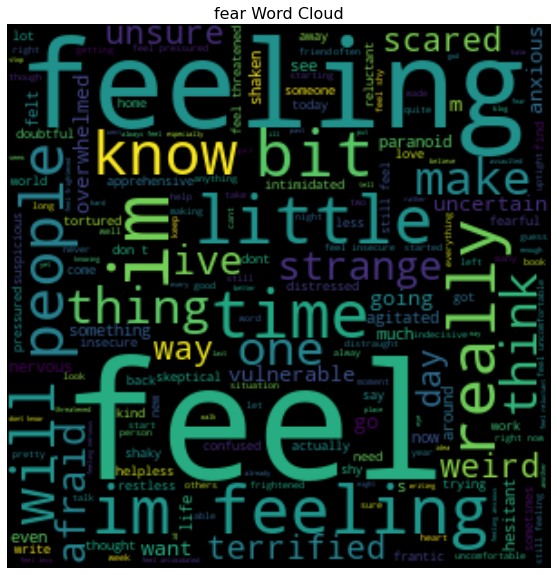

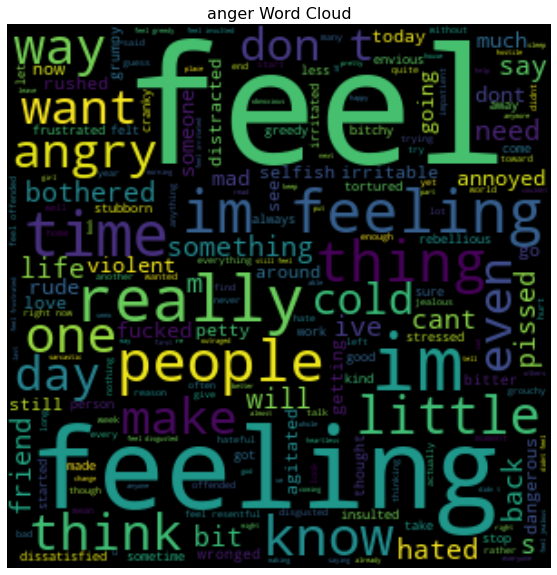

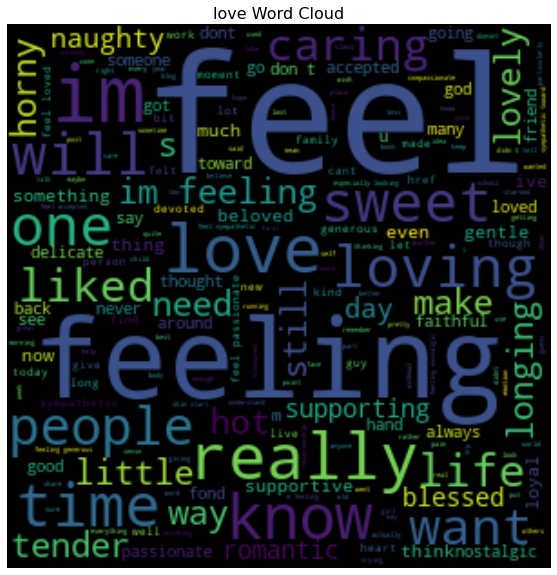

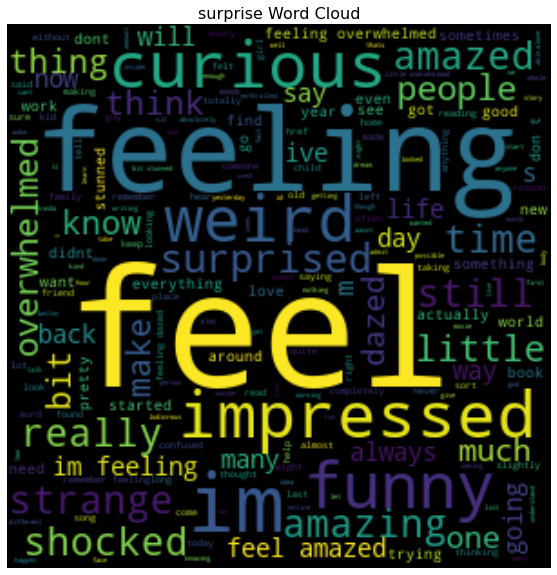

In [69]:
# Generate word clouds for each distinct emotion
emotion_list = emotions_df.Emotion.unique()

for emotion in emotion_list:
    text = ' '.join([sentence for sentence in emotions_df.loc[emotions_df['Emotion']==emotion,'Text']])
    wordcloud = WordCloud(width = 300, height = 300).generate(text)

    plt.figure(figsize=(10, 10))
    plt.title(emotion+' Word Cloud', size=16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

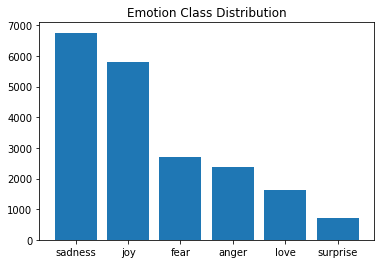

In [70]:
# View distribution of emotions in data set
plt.bar(emotion_list, height=emotions_df.Emotion.value_counts())
plt.title('Emotion Class Distribution')
plt.show()

In [71]:
# Encode labels for Emotion classes
le = LabelEncoder()
emotions_df.Emotion = le.fit_transform(emotions_df.Emotion)

In [72]:
# Split data set into 3 separate dataframes;
# 80% training, 10% validation, 10% test
train, validate, test = np.split(
    emotions_df.sample(frac=1), 
    [int(.8*len(emotions_df)), int(.9*len(emotions_df))]
    )

X_train = train.Text
y_train = train.Emotion

X_val = validate.Text
y_val = validate.Emotion

X_test = test.Text
y_test = test.Emotion

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [73]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

In [74]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean(series):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in series:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    print(pad.shape)
    return pad

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/winphyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
X_train = clean(X_train)
X_val = clean(X_val)
X_test = clean(X_test)

(16000, 300)
(2000, 300)
(2000, 300)


In [76]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          3048800   
                                                                 
 dropout (Dropout)           (None, 300, 200)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [77]:
callback = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
    )

# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
250/250 [==============================] - 179s 709ms/step - loss: 1.4526 - accuracy: 0.4238 - val_loss: 0.9367 - val_accuracy: 0.6840
Epoch 2/10
250/250 [==============================] - 177s 709ms/step - loss: 0.5691 - accuracy: 0.8182 - val_loss: 0.4344 - val_accuracy: 0.8590
Epoch 3/10
250/250 [==============================] - 182s 728ms/step - loss: 0.2810 - accuracy: 0.9061 - val_loss: 0.3347 - val_accuracy: 0.8845
Epoch 4/10
250/250 [==============================] - 193s 770ms/step - loss: 0.1822 - accuracy: 0.9396 - val_loss: 0.3016 - val_accuracy: 0.8900
Epoch 5/10
250/250 [==============================] - 214s 855ms/step - loss: 0.1287 - accuracy: 0.9555 - val_loss: 0.3303 - val_accuracy: 0.8860
Epoch 6/10
250/250 [==============================] - 205s 821ms/step - loss: 0.1107 - accuracy: 0.9613 - val_loss: 0.3608 - val_accuracy: 0.8805


In [83]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 11s 152ms/step - loss: 0.3016 - accuracy: 0.8900


[0.30155712366104126, 0.8899999856948853]

In [79]:
model.evaluate(X_test, y_test, verbose=1)

63/63 [==============================] - 12s 183ms/step - loss: 0.2763 - accuracy: 0.9000


[0.2763170003890991, 0.8999999761581421]

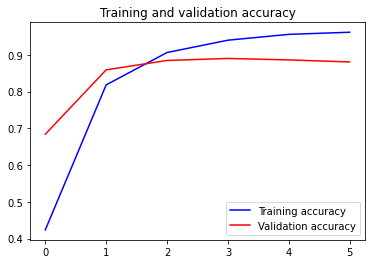

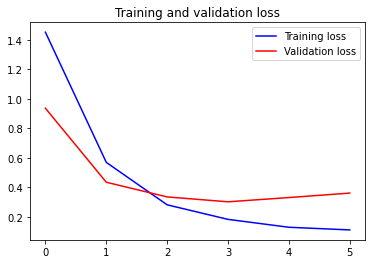

In [80]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [81]:
def clean_new(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    return pad

In [85]:
sentences = [
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean_new(sentence)
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    probability =  np.max(model.predict(sentence))
    print(f"{result} : {probability}\n\n")

He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 38ms/step
joy : 0.4717341661453247


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 47ms/step
anger : 0.8275076150894165


I feel like im all alone in this world
1/1 [==============================] - 0s 40ms/step
sadness : 0.989284098148346


He is really sweet and caring
1/1 [==============================] - 0s 42ms/step
love : 0.7478350400924683




In [102]:
with open('er-tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('er-labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)

model.save('emotion-recognition-model.h5')
